In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
 # Making a connection between sqlite3 
    # database and Python Program
sqliteConnection = sqlite3.connect('data.db')
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
cursor = sqliteConnection.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[('balances',), ('client_products',), ('client',), ('inv_campaign_eval',)]


In [3]:
balances_query = """SELECT * FROM balances"""
balances_df = pd.read_sql_query(balances_query, sqliteConnection)

client_products_query = """SELECT * FROM client_products"""
client_products_df = pd.read_sql_query(client_products_query, sqliteConnection)

client_query = """SELECT * FROM client"""
client_df = pd.read_sql_query(client_query, sqliteConnection)

inv_camp_query = "SELECT * FROM inv_campaign_eval" 
inv_camp_df = pd.read_sql_query(inv_camp_query, sqliteConnection)


In [4]:
client_df['age'] = client_df['age'].fillna(client_df['age'].median())
print(client_df)
client_df.isnull().sum()

new_client_df = client_df.drop('job', axis=1)
print(new_client_df)
new_client_df.isnull().sum()

        client_id   age            job   marital  education gender
0       249789938  38.0       services   married  secondary      M
1      1222646323  46.0       services  divorced    unknown      M
2       451375919  33.0         admin.    single  secondary      F
3       338972671  44.0  self-employed   married  secondary      F
4      1472834688  36.0    blue-collar   married    primary      M
...           ...   ...            ...       ...        ...    ...
11157   543198889  40.0    blue-collar    single    unknown      M
11158   458558558  41.0      housemaid  divorced    primary      F
11159  1426334329  59.0     technician   married    primary      F
11160   831035343  42.0     management   married   tertiary      M
11161   705801685  36.0    blue-collar    single  secondary      F

[11162 rows x 6 columns]
        client_id   age   marital  education gender
0       249789938  38.0   married  secondary      M
1      1222646323  46.0  divorced    unknown      M
2       451375

client_id    0
age          0
marital      0
education    0
gender       0
dtype: int64

In [5]:
client_products_df = client_products_df.replace(['n'], 'no')
client_products_df = client_products_df.replace(['y'], 'yes')

In [6]:
new_client_df['age'] = new_client_df['age'].astype(int)
print(new_client_df)

        client_id  age   marital  education gender
0       249789938   38   married  secondary      M
1      1222646323   46  divorced    unknown      M
2       451375919   33    single  secondary      F
3       338972671   44   married  secondary      F
4      1472834688   36   married    primary      M
...           ...  ...       ...        ...    ...
11157   543198889   40    single    unknown      M
11158   458558558   41  divorced    primary      F
11159  1426334329   59   married    primary      F
11160   831035343   42   married   tertiary      M
11161   705801685   36    single  secondary      F

[11162 rows x 5 columns]


In [7]:
df_balance_new = balances_df.copy()
df_balance_new.loc[df_balance_new['balance'] == 'USD', 'currency':] *= 23
df_balance_new.loc[df_balance_new['currency'] == 'USD', 'currency'] = "CZK"
df_balance_new.loc[df_balance_new['balance'] == 'EUR', 'currency':] *= 25
df_balance_new.loc[df_balance_new['currency'] == 'EUR', 'currency'] = "CZK"
print(df_balance_new)

                              date      balance  client_id currency
0       2023-06-06 16:21:15.291346  2680.467773  249789938      CZK
1       2023-05-23 16:21:15.291346  2654.055419  249789938      CZK
2       2023-05-09 16:21:15.291346  2620.835872  249789938      CZK
3       2023-04-25 16:21:15.291346  2720.315925  249789938      CZK
4       2023-04-11 16:21:15.291346  2687.601982  249789938      CZK
...                            ...          ...        ...      ...
290207  2022-08-16 16:22:46.440217   145.454161  705801685      CZK
290208  2022-08-02 16:22:46.440217    -5.497494  705801685      CZK
290209  2022-07-19 16:22:46.440217   -45.891607  705801685      CZK
290210  2022-07-05 16:22:46.440217    19.473946  705801685      CZK
290211  2022-06-21 16:22:46.440217   163.032053  705801685      CZK

[290212 rows x 4 columns]


In [8]:
filtered_df = df_balance_new[(df_balance_new['date'] >= '2023-03-01') & (df_balance_new['date'] <= '2023-06-30')]
print(filtered_df)


                              date      balance  client_id currency
0       2023-06-06 16:21:15.291346  2680.467773  249789938      CZK
1       2023-05-23 16:21:15.291346  2654.055419  249789938      CZK
2       2023-05-09 16:21:15.291346  2620.835872  249789938      CZK
3       2023-04-25 16:21:15.291346  2720.315925  249789938      CZK
4       2023-04-11 16:21:15.291346  2687.601982  249789938      CZK
...                            ...          ...        ...      ...
290188  2023-05-09 16:22:46.440217    40.666162  705801685      CZK
290189  2023-04-25 16:22:46.440217     8.617271  705801685      CZK
290190  2023-04-11 16:22:46.440217    84.358039  705801685      CZK
290191  2023-03-28 16:22:46.440217   -16.975446  705801685      CZK
290192  2023-03-14 16:22:46.440217    16.844223  705801685      CZK

[78134 rows x 4 columns]


In [9]:
sum_balances = filtered_df.groupby('client_id')['balance'].sum()

# Divide each sum by 7 and create a new DataFrame
average_balances_df = pd.DataFrame({'client_id': sum_balances.index, 'average_balance': sum_balances.values / 7})

# Print the result
print(average_balances_df)

        client_id  average_balance
0       100070076       214.655340
1       100141910      2533.575687
2       100207570       -10.465497
3       100488560       366.843373
4       100605013       409.905114
...           ...              ...
11157  1999463182      1241.009897
11158  1999499145       -17.706274
11159  1999715381       703.327991
11160  1999945413      5035.928297
11161  1999956516       238.364484

[11162 rows x 2 columns]


In [10]:
all_customers = pd.merge(pd.merge(pd.merge(inv_camp_df, average_balances_df, on='client_id', how='outer'), client_products_df, on='client_id', how='outer'), new_client_df, on='client_id', how='outer')


In [11]:
all_customers = all_customers.replace({"M":1, "F":0, "yes":1, "no":0, "y":1, "n":0, "success":1, "failure":0 })

In [12]:
all_customers_encoded = pd.get_dummies(all_customers)

In [13]:
all_customers_encoded.head()

,client_id,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,249789938,1.0,2673.410334,1,0,0,0,38,1,False,True,False,False,True,False,False
1,1504633819,0.0,5426.688121,0,1,0,1,38,1,False,True,False,False,False,True,False
2,1952195738,1.0,2896.273313,1,1,0,0,34,1,False,True,False,False,True,False,False
3,989726384,1.0,3115.820938,1,0,0,0,62,0,False,True,False,False,True,False,False
4,1971878545,0.0,492.085398,1,0,0,0,36,1,False,False,True,False,False,True,False


In [121]:
fig = px.box(all_customers, x="has_deposits", y="average_balance", color="poutcome")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [14]:
all_customers_drop = all_customers.drop(['poutcome'], axis=1)

In [15]:
train_test_data = all_customers_encoded[~(all_customers_encoded.poutcome.isna())] #NON CONTACTED
to_apply_data = all_customers_encoded[(all_customers_encoded.poutcome.isna())] #CONTACTED

In [16]:
X = train_test_data.drop("poutcome", axis = 1)
y = train_test_data["poutcome"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "LogisticRegression": LogisticRegression()
}



In [19]:
results = []

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Classification Report": report,
        "FPR": fpr,
        "TPR": tpr,
        "AUC": roc_auc
    })

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

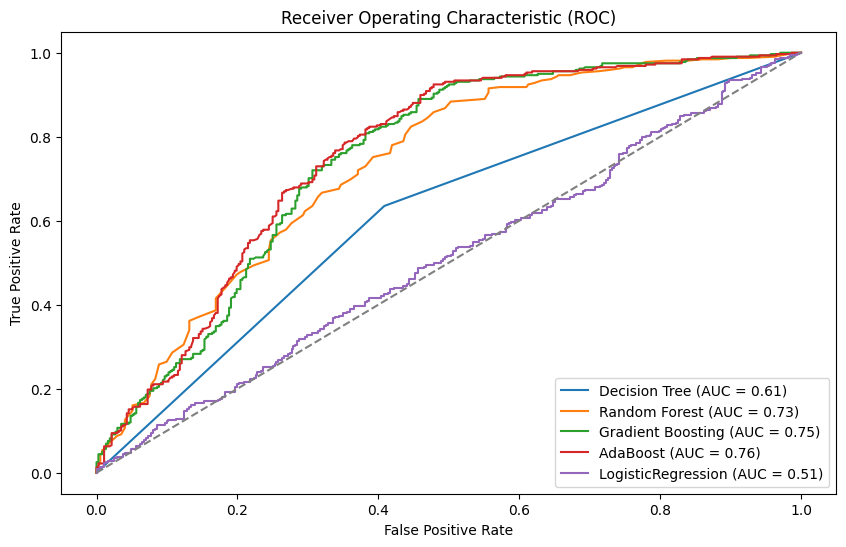

In [20]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['FPR'], result['TPR'], label=f"{result['Classifier']} (AUC = {result['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Create a bar chart comparing accuracy
accuracy_df = pd.DataFrame(results)
fig = px.bar(accuracy_df, x='Classifier', y='Accuracy', text='Accuracy', title='Classifier Accuracy Comparison')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()

In [22]:
tree = DecisionTreeClassifier(
          max_depth=1,
          random_state=42)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [23]:
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

In [24]:
ada = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=125,
    learning_rate=0.5,
    random_state=42)

In [25]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



In [26]:
print(f'Adaboost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')


Adaboost train/test accuracies: 0.728/0.714


In [27]:
to_apply_data = all_customers_encoded[(all_customers_encoded.poutcome.isna())]
Non_contacted_customers = to_apply_data.drop(['poutcome'], axis=1)
Non_contacted_customers

,client_id,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
2299,100070076,214.655340,0,0,0,0,41,1,True,False,False,False,False,True,False
2300,100141910,2533.575687,0,0,0,1,34,0,False,False,True,False,False,True,False
2301,100207570,-10.465497,1,0,0,0,34,0,False,False,True,False,False,True,False
2302,100646594,37140.331804,0,0,0,0,75,0,True,False,False,True,False,False,False
2303,100741497,226.957688,0,0,0,1,56,1,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,1999460711,205.463959,0,1,0,1,53,1,True,False,False,False,True,False,False
11158,1999463182,1241.009897,0,0,0,1,34,1,False,True,False,False,True,False,False
11159,1999499145,-17.706274,0,0,0,1,31,0,False,False,True,False,False,True,False
11160,1999715381,703.327991,1,0,0,1,24,1,False,True,False,False,True,False,False


In [28]:
Outcomes = ada.predict_proba(Non_contacted_customers)
Outcomes.shape

(8863, 2)

In [29]:
Outcomes_flattened = Outcomes[...,1]

In [30]:
Outcomes_flattened.shape

(8863,)

In [31]:
Non_contacted_customers["probability"] = Outcomes_flattened

In [32]:
len(Non_contacted_customers)

8863

In [33]:
Non_contacted_customers_sorted = Non_contacted_customers.sort_values('probability', ascending = False)
Non_contacted_customers_sorted.head()
Non_contacted_customers_with_money = Non_contacted_customers_sorted.drop(Non_contacted_customers_sorted[Non_contacted_customers_sorted['average_balance'] < 0].index)



In [34]:
threek_customers = Non_contacted_customers_with_money.head(3000)
len(Non_contacted_customers_with_money)

7812

In [35]:
threek_customers.head()
threek_customers.probability.unique()

array([0.57935697, 0.57927582, 0.57829179, ..., 0.49863397, 0.49862769,
       0.49862259])

In [36]:
customer_target_ids = threek_customers['client_id']

In [37]:
customer_target_ids.reset_index()

,index,client_id
0,3880,458110879
1,10918,1951922656
2,4618,618893370
3,8516,1441287851
4,3883,458435302
...,...,...
2995,3278,323042556
2996,3592,392351982
2997,6359,974026187
2998,10666,1897435808


In [38]:
#customer_target_ids.to_csv('/Users/braverun/codingbootcamp/customer_target_ids2.csv')

In [39]:
column_sum_PROB = threek_customers['probability'].sum()
print(column_sum_PROB)
column_mean_AVGBAL = threek_customers['average_balance'].mean()
print(column_mean_AVGBAL)
ESales= column_sum_PROB * column_mean_AVGBAL
print(ESales)
ERevenue = ESales - (1271.7384347694876 * 1000)
print(ERevenue)

1510.8801964405134
2173.9326587586215
3284551.8025136734
2012813.3677441857


**Phase Two**

In [40]:
phase2 = pd.read_csv(r"/Users/Montoya-MolinaS/Repo/cb_case_study/second_phase_target_labeled.csv")
phase2.head()

,Unnamed: 0,target,client_id,poutcome
0,0,458110879,458110879,1
1,1,1951922656,1951922656,1
2,2,618893370,618893370,1
3,3,1441287851,1441287851,1
4,4,458435302,458435302,1


In [41]:
threek_customers.head()

,client_id,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,probability
3880,458110879,101.942029,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579357
10918,1951922656,129.437118,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579276
4618,618893370,401.466957,1,0,0,0,19,1,False,False,True,False,True,False,False,0.578292
8516,1441287851,753.801936,1,0,0,0,19,0,False,False,True,False,False,False,True,0.578157
3883,458435302,19.406637,1,0,0,0,18,0,False,False,True,False,False,False,True,0.577998


In [42]:
threek_outcome = threek_customers.set_index('client_id').join(phase2.set_index('client_id'))

In [43]:
threek_outcome.head()

,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,gender,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,probability,Unnamed: 0,target,poutcome
client_id,,,,,,,,,,,,,,,,,,
458110879,101.942029,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579357,0,458110879,1
1951922656,129.437118,1,0,0,0,18,1,False,False,True,False,False,False,True,0.579276,1,1951922656,1
618893370,401.466957,1,0,0,0,19,1,False,False,True,False,True,False,False,0.578292,2,618893370,1
1441287851,753.801936,1,0,0,0,19,0,False,False,True,False,False,False,True,0.578157,3,1441287851,1
458435302,19.406637,1,0,0,0,18,0,False,False,True,False,False,False,True,0.577998,4,458435302,1


In [44]:
fig = px.histogram(threek_outcome, x='average_balance', color='poutcome', marginal="box", # can be `box`, `violin`
                         hover_data=threek_outcome.columns)
fig.show()
### average_balance is a good outcome feature to support the model 

In [45]:
df_ret_1 = threek_customers.set_index('client_id').join(all_customers.set_index('client_id'), lsuffix="threek")


In [46]:
df_ret_2 = df_ret_1.drop(['loanthreek', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown'], axis=1)

In [47]:
df_ret_2

,average_balancethreek,has_depositsthreek,has_insurancethreek,has_mortgagethreek,agethreek,genderthreek,marital_divorced,marital_married,marital_single,probability,poutcome,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender
client_id,,,,,,,,,,,,,,,,,,,,
458110879,101.942029,1,0,0,18,1,False,False,True,0.579357,NaN,101.942029,1,0,0,0,18,single,unknown,1
1951922656,129.437118,1,0,0,18,1,False,False,True,0.579276,NaN,129.437118,1,0,0,0,18,single,unknown,1
618893370,401.466957,1,0,0,19,1,False,False,True,0.578292,NaN,401.466957,1,0,0,0,19,single,secondary,1
1441287851,753.801936,1,0,0,19,0,False,False,True,0.578157,NaN,753.801936,1,0,0,0,19,single,unknown,0
458435302,19.406637,1,0,0,18,0,False,False,True,0.577998,NaN,19.406637,1,0,0,0,18,single,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323042556,70.658979,1,0,1,32,1,False,True,False,0.498639,NaN,70.658979,1,0,0,1,32,married,primary,1
392351982,191.633689,1,0,1,29,0,False,True,False,0.498636,NaN,191.633689,1,1,0,1,29,married,tertiary,0
974026187,8.919169,1,0,1,46,0,True,False,False,0.498634,NaN,8.919169,1,0,0,1,46,divorced,primary,0


In [48]:
# Replace Values in a specific Column
df_ret_2['gender_all'] = df_ret_2['gender'].replace({1:"M", 0:"F"})

In [49]:
df_ret_2

,average_balancethreek,has_depositsthreek,has_insurancethreek,has_mortgagethreek,agethreek,genderthreek,marital_divorced,marital_married,marital_single,probability,...,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender,gender_all
client_id,,,,,,,,,,,,,,,,,,,,,
458110879,101.942029,1,0,0,18,1,False,False,True,0.579357,...,101.942029,1,0,0,0,18,single,unknown,1,M
1951922656,129.437118,1,0,0,18,1,False,False,True,0.579276,...,129.437118,1,0,0,0,18,single,unknown,1,M
618893370,401.466957,1,0,0,19,1,False,False,True,0.578292,...,401.466957,1,0,0,0,19,single,secondary,1,M
1441287851,753.801936,1,0,0,19,0,False,False,True,0.578157,...,753.801936,1,0,0,0,19,single,unknown,0,F
458435302,19.406637,1,0,0,18,0,False,False,True,0.577998,...,19.406637,1,0,0,0,18,single,unknown,0,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323042556,70.658979,1,0,1,32,1,False,True,False,0.498639,...,70.658979,1,0,0,1,32,married,primary,1,M
392351982,191.633689,1,0,1,29,0,False,True,False,0.498636,...,191.633689,1,1,0,1,29,married,tertiary,0,F
974026187,8.919169,1,0,1,46,0,True,False,False,0.498634,...,8.919169,1,0,0,1,46,divorced,primary,0,F


In [50]:
df_ret_3 = df_ret_2.replace(0, 'no')
df_ret_4 = df_ret_3.replace(1, 'yes')


In [51]:
df_ret_4.columns

Index(['average_balancethreek', 'has_depositsthreek', 'has_insurancethreek',
       'has_mortgagethreek', 'agethreek', 'genderthreek', 'marital_divorced',
       'marital_married', 'marital_single', 'probability', 'poutcome',
       'average_balance', 'has_deposits', 'loan', 'has_insurance',
       'has_mortgage', 'age', 'marital', 'education', 'gender', 'gender_all'],
      dtype='object')

In [56]:
df_ret_4

,average_balancethreek,has_depositsthreek,has_insurancethreek,has_mortgagethreek,agethreek,genderthreek,marital_divorced,marital_married,marital_single,probability,...,average_balance,has_deposits,loan,has_insurance,has_mortgage,age,marital,education,gender,gender_all
client_id,,,,,,,,,,,,,,,,,,,,,
458110879,101.942029,yes,no,no,18,yes,False,False,True,0.579357,...,101.942029,yes,no,no,no,18,single,unknown,yes,M
1951922656,129.437118,yes,no,no,18,yes,False,False,True,0.579276,...,129.437118,yes,no,no,no,18,single,unknown,yes,M
618893370,401.466957,yes,no,no,19,yes,False,False,True,0.578292,...,401.466957,yes,no,no,no,19,single,secondary,yes,M
1441287851,753.801936,yes,no,no,19,no,False,False,True,0.578157,...,753.801936,yes,no,no,no,19,single,unknown,no,F
458435302,19.406637,yes,no,no,18,no,False,False,True,0.577998,...,19.406637,yes,no,no,no,18,single,unknown,no,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323042556,70.658979,yes,no,yes,32,yes,False,True,False,0.498639,...,70.658979,yes,no,no,yes,32,married,primary,yes,M
392351982,191.633689,yes,no,yes,29,no,False,True,False,0.498636,...,191.633689,yes,yes,no,yes,29,married,tertiary,no,F
974026187,8.919169,yes,no,yes,46,no,True,False,False,0.498634,...,8.919169,yes,no,no,yes,46,divorced,primary,no,F


In [55]:
fig = px.bar(df_ret_4, x="education", y="average_balance", color="gender", barmode="group")
fig.show() #categories of the prediction

In [95]:
result = threek_outcome.merge(all_customers, how='left', on='client_id')

In [96]:
df_ref = result['poutcome_x'].replace({1:"success", 0:"Fail"})

In [94]:
df_ret.poutcome_x

AttributeError: 'Series' object has no attribute 'poutcome_x'

In [88]:
result.columns

Index(['client_id', 'average_balance_x', 'has_deposits_x', 'loan_x',
       'has_insurance_x', 'has_mortgage_x', 'age_x', 'gender_x',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'probability', 'Unnamed: 0', 'target',
       'poutcome_x', 'poutcome_y', 'average_balance_y', 'has_deposits_y',
       'loan_y', 'has_insurance_y', 'has_mortgage_y', 'age_y', 'marital',
       'education', 'gender_y'],
      dtype='object')

In [ ]:
#figure deposits and age
sns.boxplot(data=contacted_customers, x='has_deposits', y='age', palette='viridis')

In [78]:
fig = px.histogram(result, x='average_balance_x', color='poutcome_x', marginal="box", # can be `box`, `violin`
                         hover_data=result.columns)
fig.show()

In [99]:
fig = px.box(result, x="education", y="average_balance_x", color="poutcome_x")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [116]:
fig = px.scatter(result, x="average_balance_x", y="probability", color="has_deposits_x", hover_name="poutcome_x", size_max=60)
fig.show()


In [118]:
fig = px.box(result, x="has_deposits_x", y="average_balance_x", color="poutcome_x")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()